### Imports

In [71]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from math import pi, ceil
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [72]:
%matplotlib inline

sns.set(rc={'figure.figsize': (12,8)})

warnings.filterwarnings('ignore')

### Importando os dados

- Músicas para clusterizar

In [73]:
df_songs = pd.read_csv('datasets/songs_to_cluster.csv')
display(df_songs.info())
df_songs.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 19 columns):
album               6500 non-null object
album_id            6500 non-null object
artist              6500 non-null object
artist_id           6500 non-null object
duration_ms         6500 non-null int64
id                  6500 non-null object
name                6500 non-null object
popularity          6500 non-null int64
acousticness        6500 non-null float64
danceability        6500 non-null float64
energy              6500 non-null float64
instrumentalness    6500 non-null float64
key                 6500 non-null int64
liveness            6500 non-null float64
loudness            6500 non-null float64
mode                6500 non-null int64
speechiness         6500 non-null float64
tempo               6500 non-null float64
valence             6500 non-null float64
dtypes: float64(9), int64(4), object(6)
memory usage: 964.9+ KB


None

,album,album_id,artist,artist_id,duration_ms,id,name,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,Made In Studio 2,1VE4gyyX0wEGJEnzZ4bvbM,Márcia Fellipe,3OxZ4asD88P1lJJmLcXz4K,137826,3mf4l3O9xn8JukaUETnZFt,Chá De Sofrimento,37,0.411,0.666,0.859,0.000000,8,0.3140,-3.836,1,0.0304,156.990,0.933
1,Made In Studio 2,1VE4gyyX0wEGJEnzZ4bvbM,Márcia Fellipe,3OxZ4asD88P1lJJmLcXz4K,145883,48cryfhSXQGrWyhnmXEOEg,Nota 1.000,38,0.564,0.707,0.851,0.000094,7,0.3300,-5.008,0,0.0322,153.929,0.871
2,Deixa,7wj45LWz6uIcyBd8iqdlZ5,Bruna Magalhães,108y6vREhgAIvgvm1Cq54p,207209,0m52ru9yO561lgoMHyclcC,Deixa,0,0.801,0.299,0.159,0.000000,11,0.0611,-16.540,0,0.0357,183.227,0.180


- Músicas do usuário

In [74]:
df_user = pd.read_csv('datasets/belzedu_songs.csv')
display(df_user.info())
df_user.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 19 columns):
album               343 non-null object
album_id            343 non-null object
artist              343 non-null object
artist_id           343 non-null object
duration_ms         343 non-null int64
id                  343 non-null object
name                343 non-null object
popularity          343 non-null int64
acousticness        343 non-null float64
danceability        343 non-null float64
energy              343 non-null float64
instrumentalness    343 non-null float64
key                 343 non-null int64
liveness            343 non-null float64
loudness            343 non-null float64
mode                343 non-null int64
speechiness         343 non-null float64
tempo               343 non-null float64
valence             343 non-null float64
dtypes: float64(9), int64(4), object(6)
memory usage: 51.0+ KB


None

,album,album_id,artist,artist_id,duration_ms,id,name,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,Self-Titled,7jhH139X9JCMwKlW0SWwLY,It Looks Sad.,24M8W1AklCxyWTKjrJZDQ8,228000,71QKtFaECvOxpvHk105FMw,Ocean,38,0.002000,0.555,0.723,0.00378,9,0.0589,-6.485,1,0.0420,122.003,0.348
1,Kaiju,0Z0fNb1sXiQ7oULwQYZMUA,It Looks Sad.,24M8W1AklCxyWTKjrJZDQ8,230653,3GHB3jMQPJ6Q97JKbZCowT,Nagoya,46,0.000725,0.541,0.569,0.20600,7,0.0873,-8.497,1,0.0251,150.178,0.215
2,Sweet FA,1lhF5c8Q9bzYNwGFwQgYnP,Peach Pit,6fC2AcsQtd9h4BWELbbire,287080,0ZK8TGOsngrstVPsnrHbK1,Peach Pit,68,0.003220,0.515,0.804,0.00229,6,0.1490,-5.345,0,0.0398,123.969,0.298


In [75]:
df_songs.columns

Index(['album', 'album_id', 'artist', 'artist_id', 'duration_ms', 'id', 'name',
       'popularity', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'valence'],
      dtype='object')

### Análise do dataset de treino

- Verificando correlações entre as variaveis

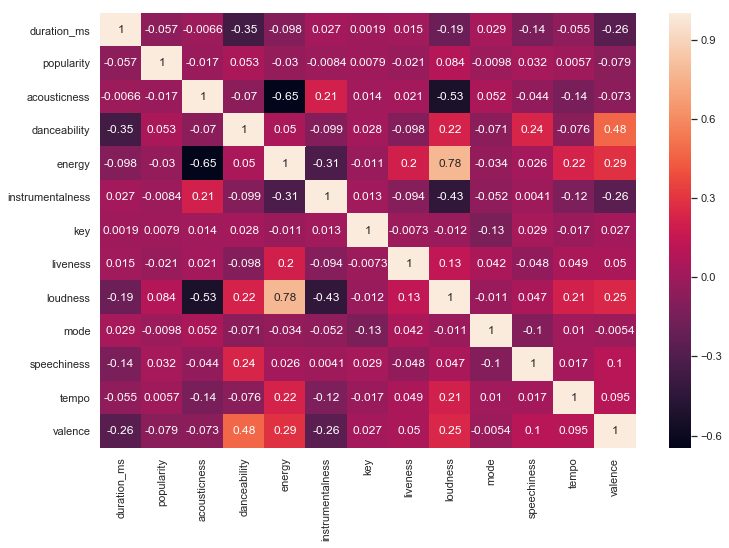

In [76]:
sns.heatmap(df_songs.corr(), annot=True)
plt.show()

- Analisando as distribuições das variáveis numericas

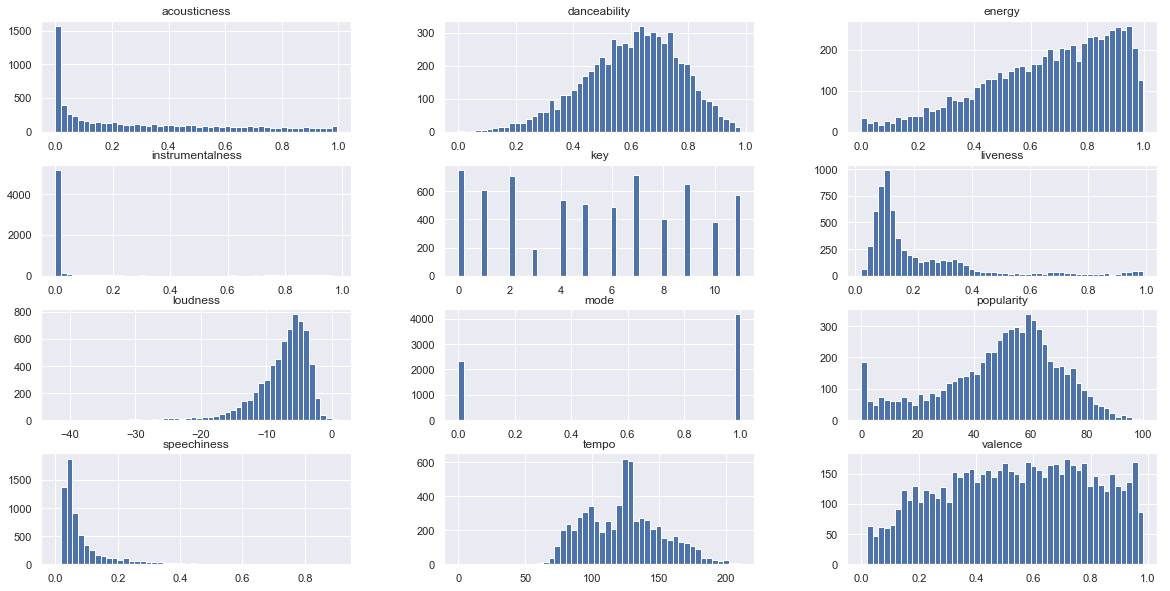

In [79]:
df_songs[['popularity', 'acousticness', 'danceability', 'energy', 
           'instrumentalness', 'key','liveness','loudness', 'mode', 'speechiness',
           'tempo', 'valence']].hist(bins=50, figsize=(20,10))
plt.show()

### Preprocessando os dados

- Mudando a escala dos dados

In [78]:
columns_to_cluster = ['acousticness', 'danceability', 'energy',
                      'instrumentalness','liveness', 'speechiness', 'valence']

ss = StandardScaler()

songs_scaled = ss.fit_transform(df_songs[columns_to_cluster])
print("Base de músicas: ", songs_scaled[0,:])

user_scaled = ss.fit_transform(df_user[columns_to_cluster])
print("Dados de usuários: ", user_scaled[0,:])

Base de músicas:  [ 0.39351789  0.36662849  0.84929458 -0.40133461  0.42960597 -0.65883238
  1.54467758]
Dados de usuários:  [-0.84345475 -0.10896899  0.20583811 -0.44974244 -0.82975614 -0.52882419
 -0.7634763 ]


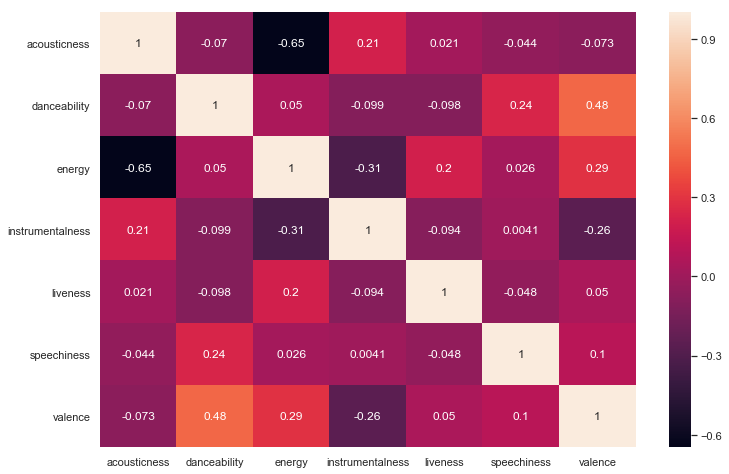

In [80]:
df_songs_scaled = pd.DataFrame(songs_scaled, columns=columns_to_cluster)
sns.heatmap(df_songs_scaled.corr(), annot=True)
plt.show()

### Desenvolvendo o modelo

In [81]:
n_clusters = range(2,21)
ssd = []

for n in n_clusters:
    km = KMeans(n_clusters=n, max_iter=300, n_init=10, init='k-means++', random_state=42)
    km.fit(songs_scaled)
    preds = km.predict(songs_scaled) 
    centers = km.cluster_centers_ 
    ssd.append(km.inertia_) 
    score = silhouette_score(songs_scaled, preds, metric='euclidean') 
    print("Number of Clusters = {}, Silhouette Score = {}".format(n, score))

Number of Clusters = 2, Silhouette Score = 0.28063148978026486
Number of Clusters = 3, Silhouette Score = 0.1975078107120194
Number of Clusters = 4, Silhouette Score = 0.219513298673411
Number of Clusters = 5, Silhouette Score = 0.23135304216442823
Number of Clusters = 6, Silhouette Score = 0.24401866503442507
Number of Clusters = 7, Silhouette Score = 0.25292575373341997
Number of Clusters = 8, Silhouette Score = 0.21604590377313848
Number of Clusters = 9, Silhouette Score = 0.20740527022220787
Number of Clusters = 10, Silhouette Score = 0.21256953896874534
Number of Clusters = 11, Silhouette Score = 0.19952102895423868
Number of Clusters = 12, Silhouette Score = 0.19680380270856998
Number of Clusters = 13, Silhouette Score = 0.19510873033327505
Number of Clusters = 14, Silhouette Score = 0.19248457474954303
Number of Clusters = 15, Silhouette Score = 0.19042920463919066
Number of Clusters = 16, Silhouette Score = 0.19105640434717236
Number of Clusters = 17, Silhouette Score = 0.18040

# PROCURAR VISUALIZAÇÕES PARA O SILHOUETTE SCORE

- Elbow method plot

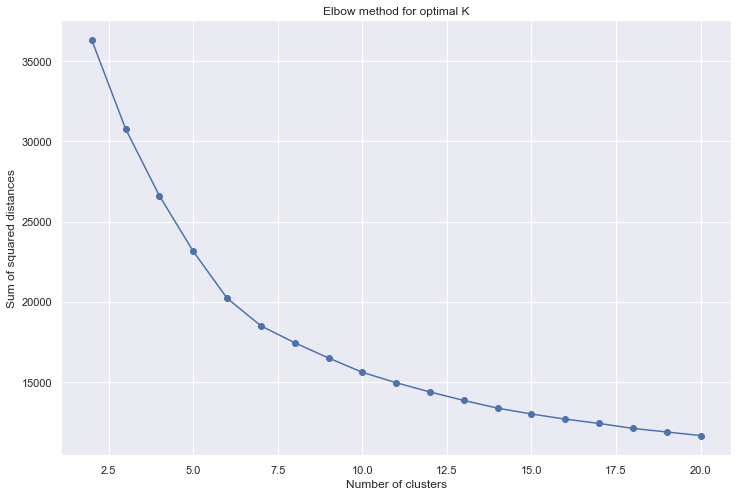

In [82]:
plt.plot(n_clusters, ssd, marker='.', markersize=12)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method for optimal K')
plt.show()

In [84]:
for n, s in zip(n_clusters, ssd):
    print('Number of Clusters = {}, Sum of Squared Distances = {}'.format(n, s))

Number of Clusters = 2, Sum of Squared Distances = 36318.995827485356
Number of Clusters = 3, Sum of Squared Distances = 30783.169240576237
Number of Clusters = 4, Sum of Squared Distances = 26603.586898963407
Number of Clusters = 5, Sum of Squared Distances = 23137.33429492488
Number of Clusters = 6, Sum of Squared Distances = 20214.649449910263
Number of Clusters = 7, Sum of Squared Distances = 18491.487074497672
Number of Clusters = 8, Sum of Squared Distances = 17433.469716432708
Number of Clusters = 9, Sum of Squared Distances = 16484.70970739595
Number of Clusters = 10, Sum of Squared Distances = 15591.66099448917
Number of Clusters = 11, Sum of Squared Distances = 14940.880521738874
Number of Clusters = 12, Sum of Squared Distances = 14363.82328037342
Number of Clusters = 13, Sum of Squared Distances = 13835.46622866365
Number of Clusters = 14, Sum of Squared Distances = 13353.968216986934
Number of Clusters = 15, Sum of Squared Distances = 12988.0668586647
Number of Clusters = 

In [106]:
k=12

model = KMeans(n_clusters=k, random_state=42).fit(songs_scaled)
pred = model.predict(songs_scaled)
print('10 primeiros clusters: ', model.labels_[:10])

10 primeiros clusters:  [5 5 9 0 5 9 9 9 0 0]


### Visualizando os clusters

- Quantidade de músicas por cluster

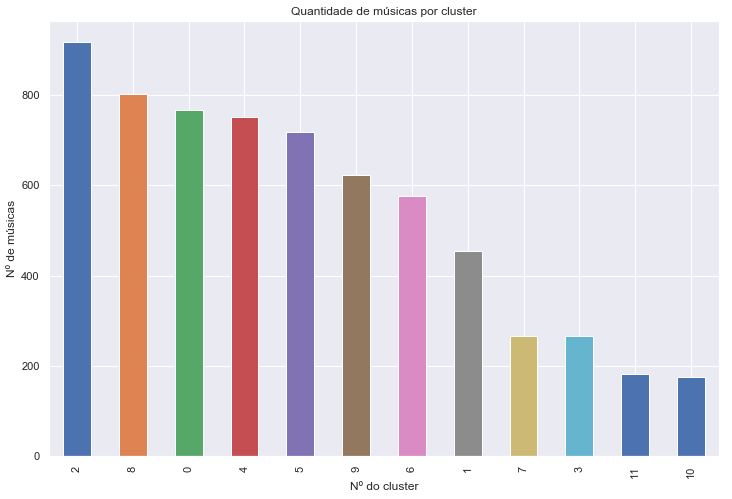

In [88]:
songs_cluster = pd.DataFrame(songs_scaled)
songs_cluster['cluster'] = model.labels_

songs_cluster['cluster'].value_counts().plot(kind='bar')
plt.xlabel('Nº do cluster')
plt.ylabel('Nº de músicas')
plt.title('Quantidade de músicas por cluster')
plt.show()

In [89]:
display(songs_cluster['cluster'].value_counts())
minor_cluster = songs_cluster['cluster'].value_counts().tail(1)
print("Qtde. músicas no menor cluster: ", int(minor_cluster.values))

2     918
8     803
0     766
4     752
5     718
9     623
6     577
1     454
7     266
3     266
11    181
10    176
Name: cluster, dtype: int64

Qtde. músicas no menor cluster:  176


- Sample de músicas de cada cluster

In [90]:
df_songs_joined = pd.concat([df_songs,songs_cluster], axis=1).set_index('cluster')

for cluster in range(k):
    display(df_songs_joined.loc[cluster, ['artist','name','album']].sample(frac=1).head(10))

,artist,name,album
cluster,,,
0,Sam Smith,Lay Me Down,Lay Me Down
0,Kiesza,Hideaway,Sound Of A Woman
0,MC Maneirinho,Me Chama,Me Chama
0,RÜFÜS DU SOL,Innerbloom (Radio Edit),Innerbloom (The Remixes)
0,Halsey,Without Me,Without Me
0,Liam Payne,Strip That Down,Strip That Down
0,Alok,Favela,Favela
0,Dfideliz,Rock N' Roll,Rock N' Roll
0,Boyz II Men,I'll Make Love To You,End Of The Road: The Collection


,artist,name,album
cluster,,,
1,Zeca Pagodinho,Deixa A Vida Me Levar,Deixa A Vida Me Levar
1,French Montana,Slide (feat. Blueface & Lil Tjay),Slide (feat. Blueface & Lil Tjay)
1,Pk,Quando a vontade bater (Participação especial ...,Quando a vontade bater (Participação especial ...
1,Sidoka,Espanha,Doka Language
1,MC Igu,Popeye,Popeye
1,Cacife Clandestino,Solo,Trilogia Triunfo
1,Emicida,Libre,Libre
1,Sinistro e Mião,Rap Do Amor,Funk Brasil Relíquias (Vol. 1)
1,Joao Nogueira,Um Gago Apaixonado,Retratos


,artist,name,album
cluster,,,
2,Maxi Priest,I'm Alright (feat. Shaggy),I'm Alright (feat. Shaggy)
2,Sean Kingston,Beautiful Girls,Beautiful Girls
2,Gil Camará,Balanço do Luiz,Nação Mameluco
2,Beastie Boys,No Sleep Till Brooklyn,Licensed To Ill
2,Sunflower Bean,Come For Me,Come For Me
2,Creedence Clearwater Revival,Bad Moon Rising,Green River (40th Anniversary Edition)
2,Bonde do Tigrão,O Baile Todo,Bonde Do Tigrão
2,Jhay Cortez,No Me Conoce - Remix,No Me Conoce (Remix)
2,Bajah,Bigger Heads,Universal Souljah


,artist,name,album
cluster,,,
3,Seneca B,Sunshine,Sunshine
3,.Sinh,Coastal Walks,Coastal Walks
3,A L E X,Proud of You,"Growing Up, Vol. 2"
3,Psalm Trees,Soulitude,Soulitude
3,Slumberville,Honolulu,Honolulu
3,Jobii,Salt Lamp,Runoff
3,Dontcry,Untill Sunset,Untill Sunset
3,SwuM,The Dream,O R B I T
3,Guustavv,Shifting Skies,Borta


,artist,name,album
cluster,,,
4,Guns N' Roses,Don't Cry (Original),Use Your Illusion I
4,Lotus x Montis,Giants - Dankann Remix,Giants (Remixes)
4,Dream Theater,Another Day,Images and Words
4,Zero 9:36,Aim Steady,Aim Steady
4,Project46,Rédeas,Rédeas
4,The Sugarcubes,Birthday,Life's Too Good
4,Armin van Buuren,This Is What It Feels Like,Intense
4,girl in red,bad idea!,bad idea!
4,The Animals,House Of The Rising Sun,The Best Of The Animals


,artist,name,album
cluster,,,
5,Caetano Veloso,Sampa,Muito Mais
5,Sorriso Maroto,O Impossível,O Impossível
5,Hungria Hip Hop,Coração de Aço - Acústico,Coração de Aço (Acústico)
5,Mano Walter,Juramento do Dedinho,Juramento do Dedinho
5,Iron & Wine,Call It Dreaming,Call It Dreaming
5,Zedd,Good Thing (with Kehlani),Good Thing (with Kehlani)
5,Maria,Codinome,Codinome
5,Toots & The Maytals,"Take Me Home, Country Roads",20th Century Masters: The Millennium Collectio...
5,Israel & Rodolffo,Coração de Quatro,Coração de Quatro


,artist,name,album
cluster,,,
6,Lauana Prado,Batimento De Solteira - Ao Vivo Em São Paulo /...,Verdade (Ao Vivo Em São Paulo / 2018)
6,Jorge Aragão,Enredo do meu samba - Ao vivo,Ao vivo
6,Ivete Sangalo,Festa,Festa
6,Alcione,Menino Sem Juizo,Gostoso Veneno
6,May & Karen,A de Casa Ou a da Rua - Ao Vivo,"Fragmentos, Ep1 (ao Vivo)"
6,Péricles,Até Que Durou - Ao Vivo,Até Que Durou (Ao Vivo)
6,Pontifexx,The Light,The Light
6,Rael,Aurora Boreal - Ao Vivo,Ao Vivo em SP
6,Opeth,Dignity,Dignity


,artist,name,album
cluster,,,
7,Van Halen,Eruption - 2015 Remaster,Van Halen (Remastered)
7,The Velvet Underground,I'm Waiting For The Man - Album Version (Stereo),The Velvet Underground & Nico 45th Anniversary...
7,Michael Feiner,Mantra - Axwell Cut,Mantra (Axwell Cut)
7,Through & Through,Right Now,Frames
7,Gabriel Thomaz Trio,Toilet Line,Toilet Line
7,Platinum Doug,Do It Big,Do It Big
7,Daddy's Groove,Bvulgari,Bvulgari
7,David Guetta,Your Love,Your Love
7,Steve Angello,Lights,Lights


,artist,name,album
cluster,,,
8,Rammstein,Du hast,Sehnsucht
8,Eric Clapton,Let It Rain,Eric Clapton (Deluxe Edition)
8,JM Puxado,Sob Medida,Sob Medida
8,Lagwagon,Violins,Hoss (Reissue)
8,Xand Avião,Sábado À Noite - Ao Vivo,Errejota (ao Vivo)
8,SUNMI,Gashina,SUNMI SPECIAL EDITION [Gashina]
8,Rick & Nogueira,Box do Chuveiro - Ao Vivo,Box do Chuveiro (Ao Vivo)
8,Neck Deep,Torn,Torn
8,Boys of Fall,Smooth Yazz - Bonus Track,Better Moments (Gold Edition)


,artist,name,album
cluster,,,
9,Bonnie Tyler,Total Eclipse of the Heart,Faster Than The Speed Of Night
9,Chico Buarque,João E Maria,Chico 50 Anos - O Trovador
9,Lou Reed,Perfect Day,Transformer
9,Aline Barros,Autor da Vida,Autor da Vida
9,Scorpions,Wind Of Change,Deadly Sting: The Mercury Years
9,Adele,Someone Like You,21
9,Nara Leão,Este Seu Olhar,Pure Bossa Nova
9,Bittencourt Project,Faded,Brainworms I
9,John Mayer,"Free Fallin' - Live at the Nokia Theatre, Los ...",Where the Light Is: John Mayer Live In Los Ang...


,artist,name,album
cluster,,,
10,YFG Daddy,Love And Choppa,Love And Choppa
10,Sleepdealer,Like Silk,B-Sides
10,Mc CL,Festa na Favela,Festa na Favela
10,Mc 7 Belo,Raba Safada,Raba Safada
10,Anitta,Onda diferente (feat. Papatinho),Kisses
10,Pineapple StormTv,Poesia Acústica #5: Teu Popô - Remix,Poesia Acústica #5: Teu Popô (Remix)
10,Guustavv,Daffodils,Asparuhgus
10,Redman,Tonight's Da Night,Whut? The Album
10,Mc Don Juan,Bye Bye,Bye Bye


,artist,name,album
cluster,,,
11,Robert Schumann,"Trio in D Minor, Op. 63: I. Mit Energie und Le...",Schumann: Complete Piano Trios
11,Tom Jenkinson,Voix Célestes,Voix Célestes
11,Music Lab Collective,I Just Called To Say I Love You (arr. piano),I Just Called To Say I Love You (arr. piano)
11,Johann Sebastian Bach,"Suite No.3 In D, BWV 1068: 2. Air",Albinoni: Adagio in G minor / Pachelbel: Canon
11,Aaron Copland,Appalachian Spring: VII. Doppio movimento,"Copland: Appalachian Spring, Rodeo, Billy the ..."
11,Keaton Henson,Initium,Initium
11,Krzysztof Penderecki,3 Pieces in Baroque Style: No. 1. Aria,Penderecki: Music for Chamber Orchestra
11,Kirill Richter,In Memoriam,In Memoriam
11,SwuM,Don't know why,O R B I T


- Distribução dos clusters em relação ao dataset original

In [91]:
def plot_similarities(data, variables, n_clusters):
    fig, axis = plt.subplots(nrows=n_clusters, ncols=len(variables), figsize=(20, 20))
    #fig.suptitle('Comparando distribuicoes para as caracteristicas das musicas')
    plt.tight_layout()
    for k in range(n_clusters):
        for idx, column in enumerate(variables):
            ax = axis[k][idx]
            sns.distplot(data.loc[k,column], ax=ax, label='Cluster {}'.format(k))
            sns.distplot(data[column], ax=ax, label='All clusters')
            ax.legend()
        ax = axis[k][0]
        ax.set_ylabel('Cluster {}'.format(k))

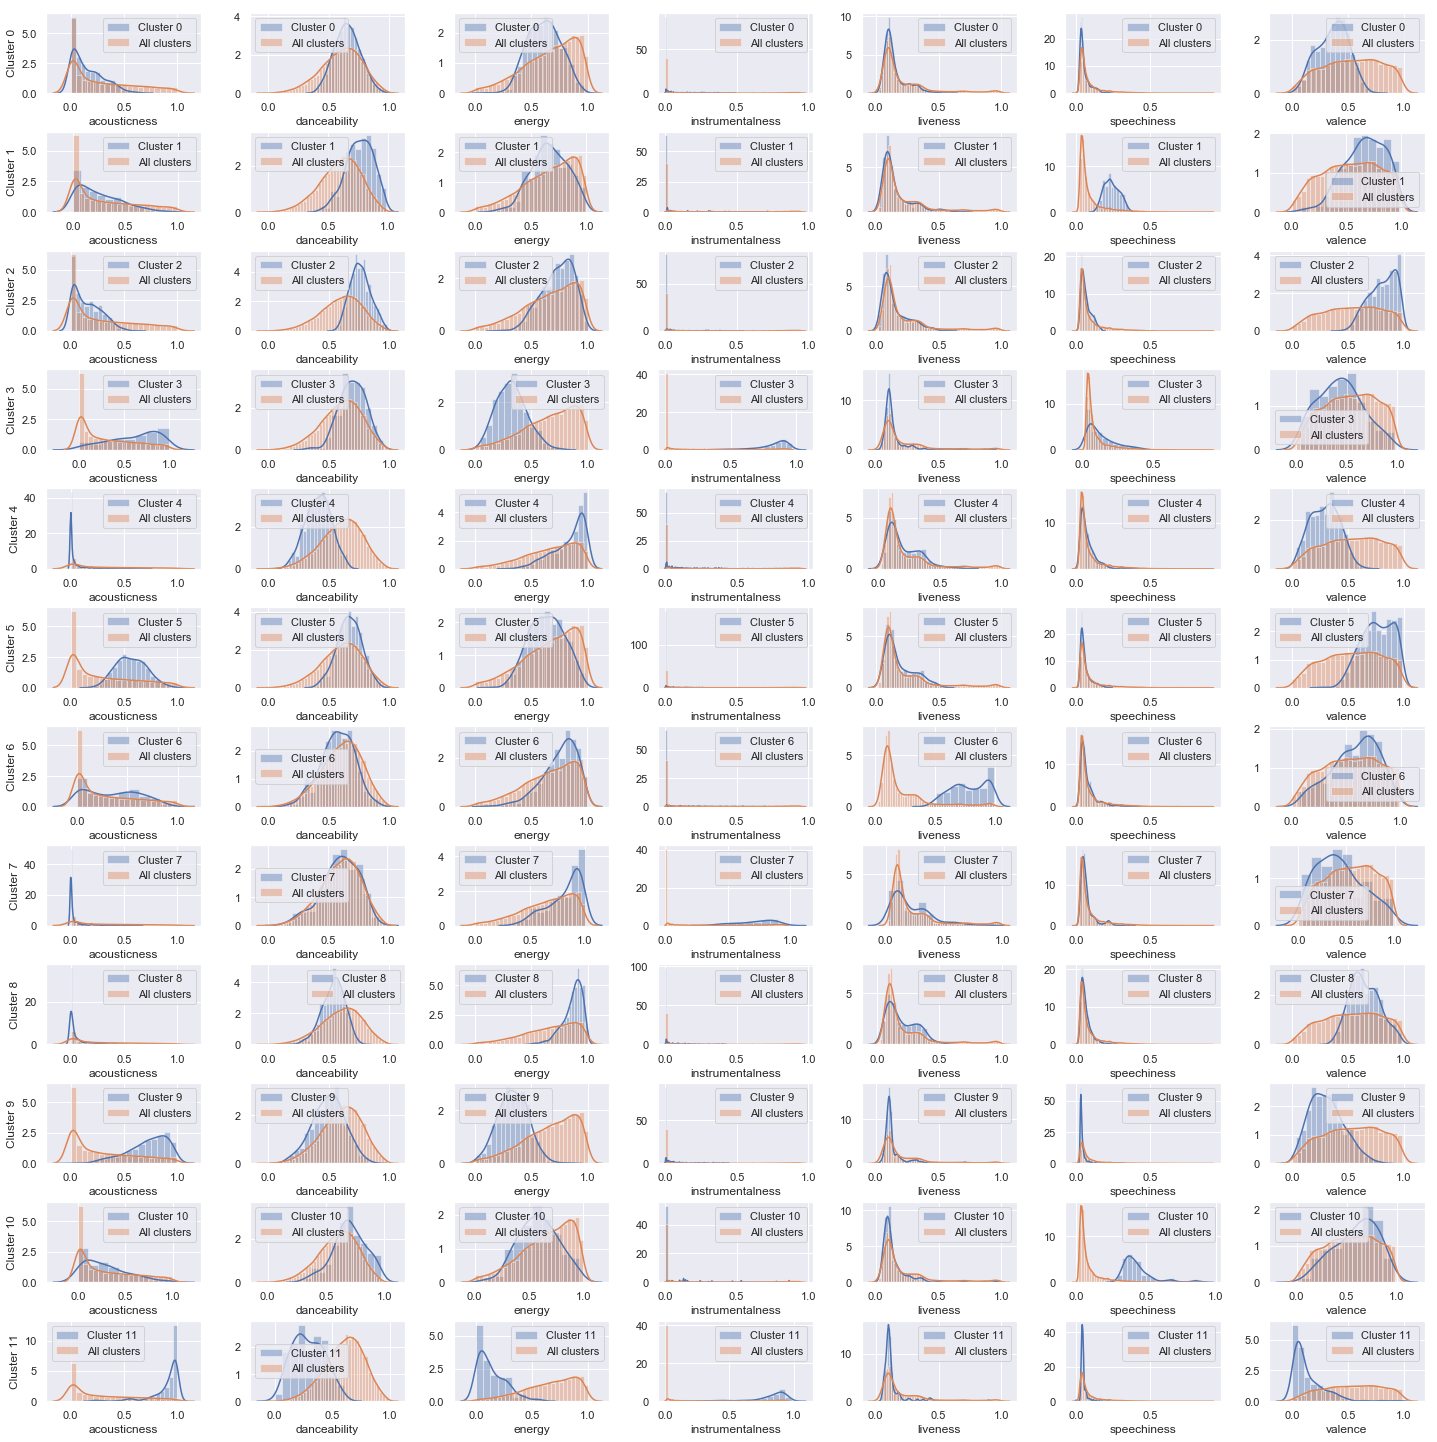

In [92]:
plot_similarities(df_songs_joined, columns_to_cluster, k)

### Gráfico de radar de cada cluster

Feito com auxilio de:
- [jkwd - Favorite songs EDA.ipynb](https://github.com/jkwd/spotify/blob/master/Code/Favourite%20songs%20EDA.ipynb)
- [#392 Use faceting for Radar chart](https://python-graph-gallery.com/392-use-faceting-for-radar-chart/)

In [94]:
df_radar = df_songs_joined.reset_index()
df_radar = df_radar.groupby('cluster')[columns_to_cluster].mean().reset_index()
df_radar

,cluster,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence
0,0,0.157734,0.653167,0.611910,0.018204,0.148558,0.056891,0.366610
1,1,0.246265,0.763740,0.668927,0.013562,0.159398,0.240511,0.668753
2,2,0.156760,0.761194,0.732389,0.015173,0.150034,0.067037,0.807929
3,3,0.611990,0.697237,0.322535,0.819331,0.152054,0.129006,0.441736
4,4,0.043261,0.413519,0.834846,0.030149,0.201287,0.076552,0.295223
5,5,0.567525,0.669067,0.634788,0.004584,0.188721,0.060733,0.761237
6,6,0.359268,0.571551,0.755650,0.011711,0.776049,0.076372,0.583931
7,7,0.042861,0.603274,0.817955,0.728492,0.214514,0.071689,0.433630
8,8,0.057859,0.538395,0.866523,0.015554,0.199131,0.065017,0.653421
9,9,0.722538,0.499230,0.336757,0.024479,0.144387,0.044846,0.312668


In [95]:
# https://python-graph-gallery.com/392-use-faceting-for-radar-chart/
def make_radar(row, title, color, dframe, num_clusters):
    # number of variable
    categories=list(dframe)[1:]
    N = len(categories)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the radar plot
    ax = plt.subplot(4,ceil(num_clusters/4),row+1, polar=True, )
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=14)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=12)
    plt.ylim(0,1)

    # Ind1
    values=dframe.loc[row].drop('cluster').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=16, color=color, y=1.06)

NOMEAR CLUSTERS

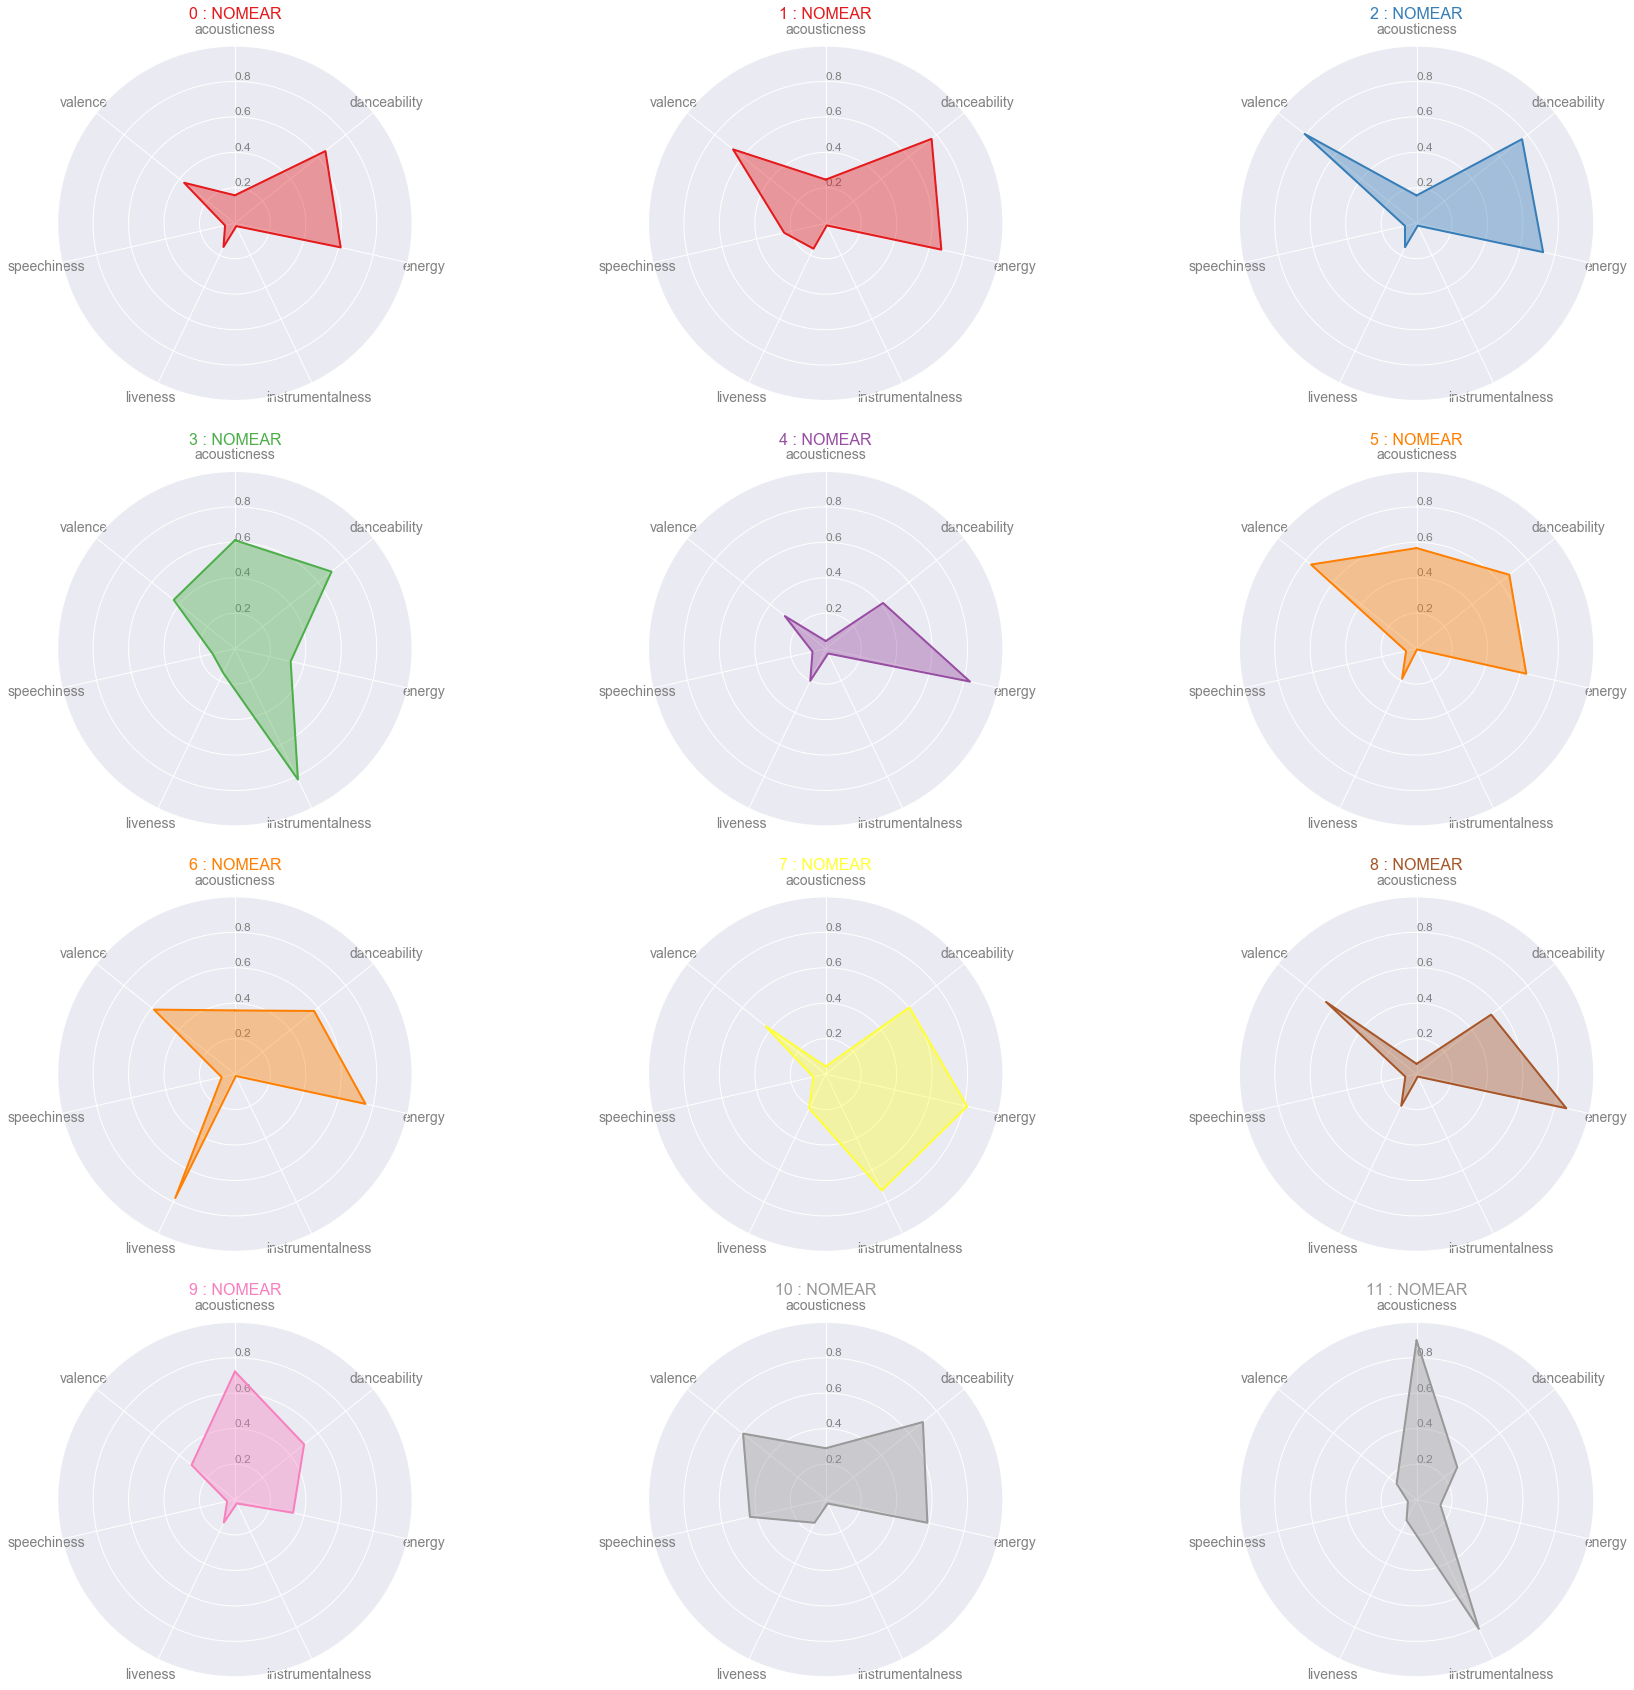

In [96]:
# initialize the figure
plt.figure(figsize=(30,30))
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set1", len(df_radar.index))

# Create cluster name
title_list = ['NOMEAR', 'NOMEAR', 'NOMEAR', 'NOMEAR', 'NOMEAR', 
              'NOMEAR', 'NOMEAR', 'NOMEAR', 'NOMEAR', 'NOMEAR',
              'NOMEAR', 'NOMEAR']

# Loop to plot
for row in range(0, len(df_radar.index)):
    make_radar(row=row, title=str(df_radar['cluster'][row]) + ' : ' + title_list[row], 
               color=my_palette(row), dframe=df_radar, num_clusters=len(df_radar.index))

### Aplicando PCA para visualizar os clusters

In [97]:
pca = PCA(n_components=3, random_state=42)
songs_pca = pca.fit_transform(songs_scaled)
pca.explained_variance_ratio_.sum()

0.6511596491888431

In [98]:
df_pca = pd.DataFrame(songs_pca, columns=['C1', 'C2', 'C3'])
df_pca['cluster'] = model.labels_
df_pca.head()

,C1,C2,C3,cluster
0,-1.189995,0.240166,1.206619,5
1,-0.911815,0.456581,1.438490,5
2,3.190573,-0.451181,0.294918,9
3,0.403301,-0.077536,-0.029764,0
4,0.098994,1.147515,-0.054486,5


- Undersampling clusters

In [99]:
sampled_clusters_pca = pd.DataFrame()

for c in df_pca.cluster.unique():
    df_cluster_sampled_pca = df_pca[df_pca.cluster == c].sample(n=int(minor_cluster), random_state=42)
    sampled_clusters_pca = pd.concat([sampled_clusters_pca,df_cluster_sampled_pca], axis=0)
sampled_clusters_pca.cluster.value_counts()

11    176
9     176
7     176
5     176
3     176
1     176
10    176
8     176
6     176
4     176
2     176
0     176
Name: cluster, dtype: int64

- Scatter plot dos clusters em 2 dimensões

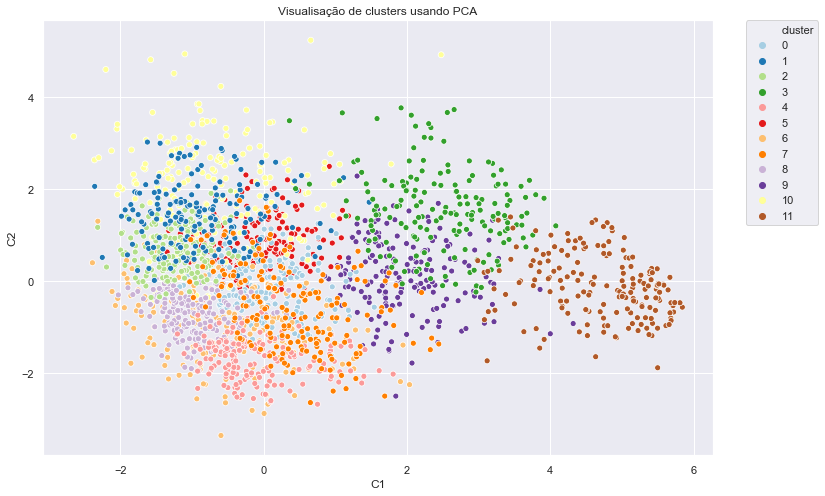

In [100]:
sns.scatterplot(x='C1', y='C2', hue='cluster', data=sampled_clusters_pca, legend="full", palette='Paired')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Visualisação de clusters usando PCA')
plt.show()

- Scatter plot dos clusters em 3 dimensões

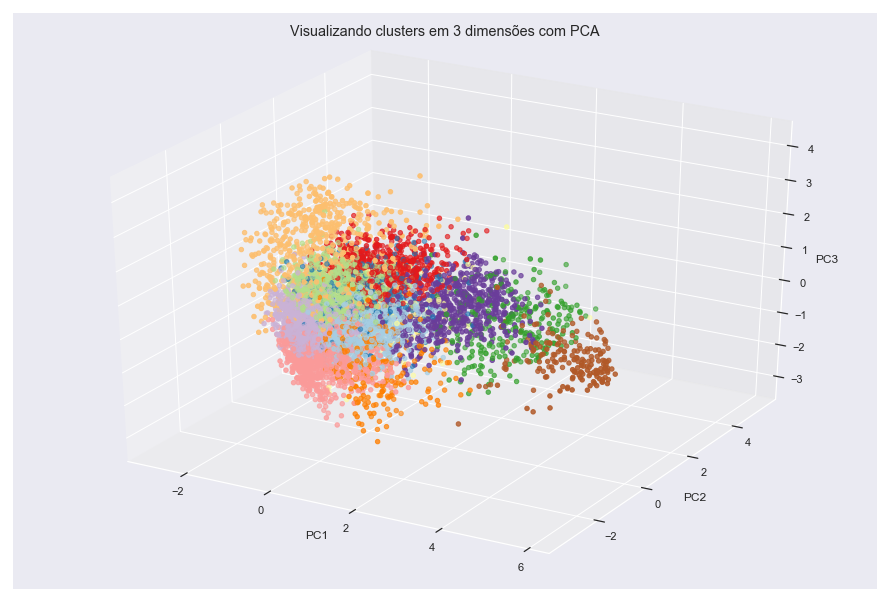

In [101]:
fig = plt.figure()
fig.suptitle('Visualizando clusters em 3 dimensões com PCA')
ax = Axes3D(fig)

ax.scatter(df_pca['C1'], df_pca['C2'], df_pca['C3'],
           c=df_pca['cluster'], cmap='Paired')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

### Aplicando t-SNE para visualizar os clusters

In [102]:
#tsne = TSNE(n_components=2, perplexity=50, n_iter=5000, random_state=42, learning_rate=190)
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
songs_tsne = tsne.fit_transform(songs_scaled)

In [103]:
df_tsne = pd.DataFrame(songs_tsne, columns=['C1', 'C2'])
df_tsne['cluster'] = model.labels_
df_tsne.head()

,C1,C2,cluster
0,-25.901789,23.477400,5
1,-24.802298,24.132275,5
2,39.669140,27.275377,9
3,13.120893,10.035134,0
4,-9.879556,11.108882,5


- Undersampling clusters

In [104]:
sampled_clusters_tsne = pd.DataFrame()

for c in df_tsne.cluster.unique():
    df_cluster_sampled_tsne = df_tsne[df_tsne.cluster == c].sample(n=int(minor_cluster), random_state=42)
    sampled_clusters_tsne = pd.concat([sampled_clusters_tsne,df_cluster_sampled_tsne], axis=0)
sampled_clusters_tsne.cluster.value_counts()

11    176
9     176
7     176
5     176
3     176
1     176
10    176
8     176
6     176
4     176
2     176
0     176
Name: cluster, dtype: int64

- Scatter plot dos clusters em 2 dimensões

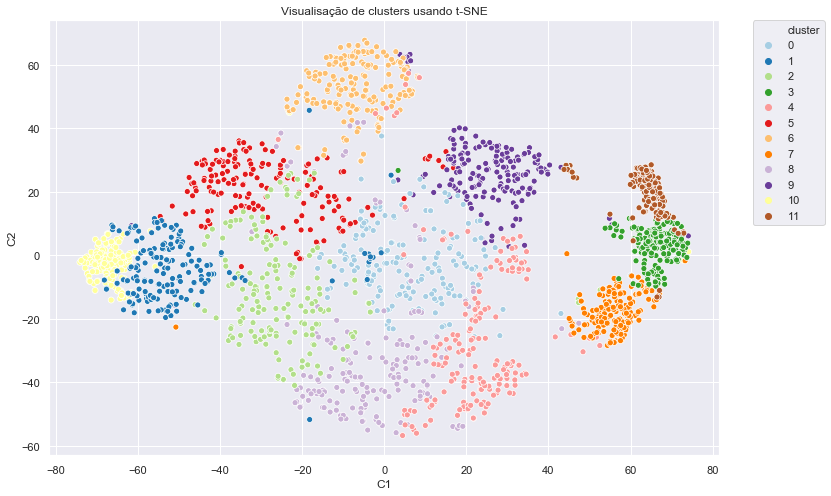

In [105]:
sns.scatterplot(x='C1', y='C2', hue='cluster', data=sampled_clusters_tsne, legend="full", palette='Paired')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Visualisação de clusters usando t-SNE')
plt.show()

- Scatter plot dos clusters em 3 dimensões

In [ ]:
# MODIFICAR TSNE NAS CELULAS ACIMA DE 2 PARA 3
fig = plt.figure()
fig.suptitle('Visualizando clusters em 3 dimensões com t-SNE')
ax = Axes3D(fig)

ax.scatter(df_tsne['C1'], df_tsne['C2'], df_tsne['C3'],
           c=df_tsne['cluster'], cmap='Paired')

ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_zlabel('C3')
plt.show()

### Prevendo os clusters do usuário

### Recomendando músicas

### EDA usuário vs nova playlist